### <font color=darkred> [MSA : Modélisation, Apprentissage et Applications] </font>
### <font color = darkblue> <div style="text-align: center"> TP - Deep Neural Networks
### <font color = darkgreen> <div style="text-align: center"> Traitements statistiques des données en grande dimension 
#### <font color = darkblue> <div style="text-align: right"> Binôme : Jordan CHEMOUHOUM, Pierrick RUGERY



Consignes rapport : 
- pas coller le code, on envoie le code a part (jupyter notebook)
- 1er partie : expliquer brièvement à ce qu'on a fait avec le RBM. Réussit à faire pour un carac, mais problème pour plusieurs carac
- 2eme partie : Pareil pour le DBN. Epxliquer les spécificités du code pour la réutilisation
- 3eme partie DNN: grande étude à faire. Le sujet principal est : DNN préentrainé vs DNN initialisé aléatoirement. On doit pas forcément comparé des entropies croisées, ce qui va être important, c'est la finalité: les taux de bonne classification. On doit travailler sur exactement les mêmes données, et comparer un DNN préentrainé et un DNN non préentrainé. On doit les comparer en fonction : 
        - du nombre de données Train(1000 puis 5000 puis 10 000, 30 000, 60 000 etc). Faire la classif sur les 10 000 données de la base test. Garder la même architecture évidemment. 
             - dans le nombre de données, faire aussi en fonction de l'architecture (faire 2 architectures). (save DNN pour plus réentrainé).
        - en fonction du nombre de couches. Prendre ici les 60 000 données Train. (1,2,...,5,6), et fixer un nombre de neurones par couche. Pour une étude complète par exemple faire cela une fois avec 50 neuroens par couche, et un autre avec 500 neurones par couche. 
         - en fonction de neurones/couches (50,100,200)
         
Faire des courbes.
Le prof prend 0.01 pour le learning rate et batch_size pour 1. 

#### Importation des librairies

In [1]:
import scipy.io
import numpy as np
import random as rd
from PIL import Image
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
from mlxtend.data import loadlocal_mnist
%matplotlib inline

# III) Fonctions élémentaires

## III.1) Construction d'un RBM et test sur Binary Alpha Digits

In [2]:
'''
Définition de la classe RBM
'''
class RBM:

    def __init__(self,W, B, A):
        self.W = W
        self.B = B
        self.A = A

    @property
    def W(self):
        return self.__W

    @property
    def B(self):
        return self.__B
    @property
    def A(self):
        return self.__A
    @W.setter
    def W(self, W):
        self.__W = W
    @B.setter
    def B(self, B):
        self.__B = B
    @A.setter
    def A(self, A):
        self.__A = A

In [3]:
'''
Fonction: permet de lire un fichier image
Input: chemin vers un fichier
Output: une matrice d'image
'''

def lire_alpha_digit(file):
    X = pd.DataFrame(scipy.io.loadmat(file)['dat'])   
    images = pd.DataFrame(np.zeros((1404, 20*16), dtype=np.int8))
    ligne = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            images.iloc[ligne,:] = np.concatenate([X.iloc[i,j][k] for k in range(20)])
            ligne += 1
    return images.as_matrix()

In [4]:
'''
Input:
    p : taille de la couche d'entrée
    q : taille de la couche de sortie
Output:
    rbm : un object RBM 
'''
def init_rbm(p,q):
    B = np.zeros(q)
    A = np.zeros(p)
    rbm = RBM(W=0.01 * np.random.randn(p, q), B=B, A=A)
    return rbm

In [69]:
def sigmoid(x):
    return(1/(1+np.exp(-x)))
'''
Input: 
    X : une matrice image
    RBM : objet de class RBM, contenant W, A, B

Output:
    PH|V : une matrice de probabilités
'''

def entree_sortie_RBM(X,RBM):
    B = np.array([RBM.B]*X.shape[0])
    return sigmoid(np.dot(X,RBM.W) - B)

In [6]:
'''
Input:
    H : matrice de probabilités
    RBM : objet de class RBM, contenant W, A, B

Output:
    PV|H : matrice de probabilités
'''

def sortie_entree_RBM(H,RBM):
    A = np.array([RBM.A]*H.shape[0])
    return sigmoid(np.dot(H,np.transpose(RBM.W)) + A)

In [7]:
'''
Input: 
    X : matrice image
    RBM : objet de class RBM, contenant W, A, B
    batch_size : int, taille de nos batchs
    nb_iteration : int, nombre d'itérations
    alpha : le learning rate

Output:
    un objet RBM entrainé et une liste contenant les erreurs quadratiques moyennes
'''
def train_RBM(X,RBM,batch_size,nb_iteration,alpha):
    EQM = []
    for iteration in range(nb_iteration):
        #shuffle inplace
        np.random.shuffle(X)
        p,q = RBM.W.shape
        for j in range(0,X.shape[0],batch_size):
            # selection des données
            data = X[j:min(j + batch_size, len(X)),:]
            n = len(data)
            
            #CD_1
                #tirage selon H|V0. Donne un tableau de False/True, mais numpy sait que c'est des 0 ou 1
        
            V0 = data
            PH_V0 = entree_sortie_RBM(V0,RBM)
            p, q = PH_V0.shape
            H0 = np.random.rand(p,q) <= PH_V0
            
            PV_H0 = sortie_entree_RBM(H0,RBM)
            p, q = PV_H0.shape
            V1 = np.random.rand(p,q) <= PV_H0
            PH_V1 = entree_sortie_RBM(V1,RBM)

            #calcul des gradients
            dW = (np.dot(np.transpose(V0),PH_V0) -  np.dot(np.transpose(V1),PH_V1))/data.shape[0]
                #somme sur les lignes
            dA = (np.sum(V0, axis=0) - np.sum(V1, axis=0))/data.shape[0]
            dB = (np.sum(PH_V0, axis=0) - np.sum(PH_V1, axis=0))/data.shape[0]

            #Actualisation
            RBM.W += alpha*dW
            RBM.A += alpha*dA
            RBM.B += alpha*dB
        
        e = entree_sortie_RBM(X, RBM)
        s = sortie_entree_RBM(e, RBM)
        EQM.append(np.mean(np.mean(X-s)**2))
        
    return(RBM,EQM)

In [8]:
'''
Input: 
    EQM : une liste contenant les erreurs quadratiques moyennes à chaque itération
Ouput: 
    Un graphe de l'evolution de l'erreur quadratique moyenne
'''
def tracer_erreur(EQM):        
    plt.plot(range(len(EQM)), EQM)
    plt.legend(['Erreur Quadratique Moyenne'])
    plt.title("Évolution de l'erreur")

In [9]:
'''
Input: 
    images : une matrice(np array) contenant une image sur chaque lignes
    size : la taille des images
Output:
    affiche les images
'''
def display(images, size):
    for image in images:
        image = image*255
        plt.imshow(np.reshape(image, size),cmap='gray')
        plt.show()

In [10]:
'''
Input: 
    RBM : un RBM entrainé
    nb_iterations : le nombre d'iterations
    nb_images : le nombre d'images à générer
    size_image : la taille souhaitée des images à générer
Ouput: 
    nb_images images générées
'''

def generer_image_RBM(RBM,nb_iterations,nb_images, size_image):
    images = []
    #initialisation
    images = np.zeros((nb_images, RBM.W.shape[0]))
    for i in range(nb_images):
        X = np.random.rand(nb_images, RBM.W.shape[0])
        comp = np.ones((nb_images, RBM.W.shape[0]))*0.5
        X = X <= comp
        for iteration in range(nb_iterations):    
            PH_V = entree_sortie_RBM(X,RBM)
            p, q = PH_V.shape
            H = (np.random.rand(p, q)) <= (PH_V)
            
            PV_H = sortie_entree_RBM(H,RBM)
            p, q = RBM.W.shape
    
            X = (np.random.rand(nb_images, p)) <= (PV_H)
        images = X
    return images

In [11]:
'''
Test des fonctions précédentes sur les données Binary AlphaDigits
Output : les images générées
'''
def principal_RBM_Alpha():
    
    # Chargement des images
    X = lire_alpha_digit('./binaryalphadigs.mat')
    
    # Initialisation des paramètres
    p = X.shape[1]
    q = 60
    batch_size = 9
    nb_iter = 1000
    nb_iter_gibbs = 1000
    nb_image = 10
    alpha = 0.1
    taille_image = [20,16]
    
    #  On mélange les données et on en sélectionne seulement 100
    np.random.shuffle(X)
    X = X[:99,:]
    
    # On initialise le RBM
    rbm = init_rbm(p, q)
    
    # On l'entraine
    rbm_train,EQM = train_RBM(X, rbm, batch_size, nb_iter, alpha)
    
    # On affiche l'évolution de l'erreur de reconstruction
    tracer_erreur(EQM)
    
    # On génére nb_image images
    images = generer_image_RBM(rbm_train, nb_iter_gibbs, nb_image, taille_image)
    
    return(images)

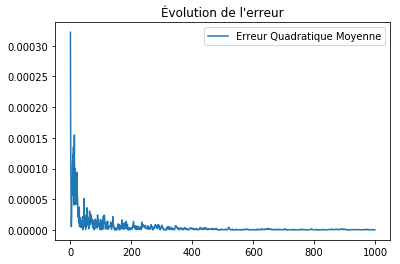

In [34]:
images = principal_RBM_Alpha()

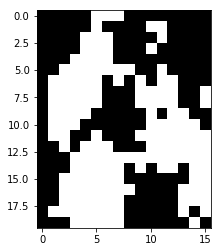

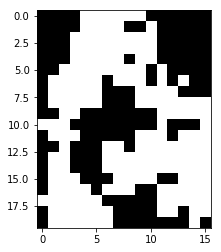

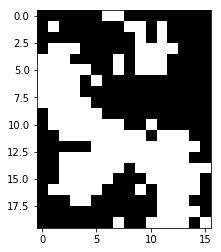

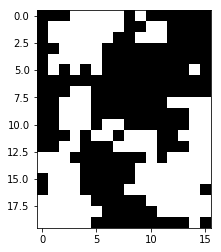

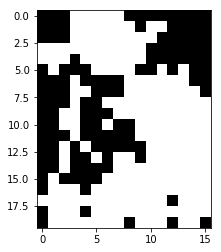

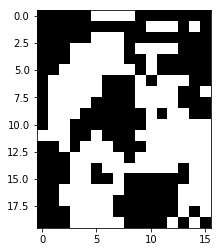

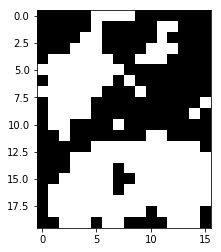

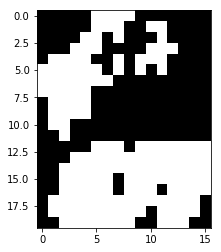

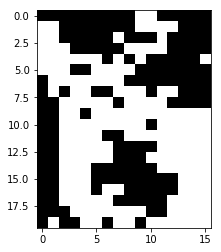

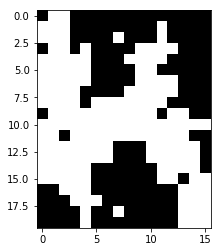

In [36]:
# On affiche les images générées
display(images,[20,16])

## III.2) Construction d'un DBN et test sur Binary Alpha Digits

In [14]:
'''
Input: 
    size: une liste contenant la taille des couches des RBM composants le DNN
Output:
    Un DNN
'''
def init_DNN(size):
    DNN = []
    for i in range(len(size)-1):
        DNN.append(init_rbm(size[i], size[i+1]))
    return DNN

In [46]:
'''
Input: 
    DNN : un DNN initialisé
    nb_iter : le nombre d'itérations
    alpha : le learning rate
    minibatch_size : la taille du minibatch
    X : une matrice d'images
Output:
    DNN_New : un DNN entrainé
'''
def train_DBN(DNN,nb_iter,alpha,minibatch_size,X):
    DNN_new = []
    data = X
    for i in range(len(DNN)):
        RBM_trained,eqm = train_RBM(data,DNN[i],minibatch_size,nb_iter,alpha)
        DNN_new.append(RBM_trained)
        data = entree_sortie_RBM(data,DNN[i])
        plt.legend('couche ' + str(i))
        
    #calcule de l'erreur
    data_err = X
    for RBM in DNN:
        PH_V = entree_sortie_RBM(data_err,RBM)
        p, q = PH_V.shape
        data_err = np.random.rand(p, q) <= PH_V

    for RBM in DNN[::-1]:
        PV_H = sortie_entree_RBM(data_err,RBM)
        data_err = np.random.rand(PV_H.shape[0], PV_H.shape[1]) <= PV_H
    
    #print("L'erreur de reconstruction du DBN est : " + str(np.mean(np.mean(X-data_err)**2)))
    return DNN_new

In [16]:
'''
Input: 
    DBN : un DBN entrainé
    nb_iterations : le nombre d'itérations
    nb_images : le nombre d'images à générer
    size_image : la taille souhaitée des images
Output:
    nb_images images générées
'''

def generer_image_DBN(DBN,nb_iterations,nb_images, size_image):   
    images = []
    images = np.zeros((nb_images, DBN[0].W.shape[0]))
    for i in range(nb_images):
        X = np.random.rand(nb_images, DBN[0].W.shape[0])
        comp = np.ones((nb_images, DBN[0].W.shape[0]))*0.5
        X = X <= comp
        for iteration in range(nb_iterations):
            
            for RBM in DBN:
                PH_V = entree_sortie_RBM(X,RBM)
                p, q = PH_V.shape
                X = (np.random.rand(p, q)) <= (PH_V)

            for RBM in DBN[::-1]:
                PV_H = sortie_entree_RBM(X,RBM)
                p, q = RBM.W.shape
                X = (np.random.rand(nb_images, p)) <= (PV_H)
        images = X
    return images 

In [43]:
'''
Test des fonctions précédentes sur les données Binary AlphaDigits
Output : les images générées
'''
def principal_DBN_alpha():
    
    # Chargement des images
    X = lire_alpha_digit('./binaryalphadigs.mat')
    
    # Initialisation des paramètres
    size = [320,160,80,10]
    minibatch_size = 9
    nb_iter = 1000
    nb_image = 10
    alpha = 0.1
    size_image = [20,16]
    
    #  On mélange les données et on en sélectionne seulement 100
    np.random.shuffle(X)
    X = X[:99,:]
    
    # On initialise le RBM
    DBN = init_DNN(size)
    
    # On l'entraine
    DBN_train = train_DBN(DBN,nb_iter,alpha,minibatch_size,X)
    
    # On génére nb_image images
    images = generer_image_DBN(DBN_train,nb_iter,nb_image, size_image)
    
    return images

L'erreur de reconstruction du DBN est : 0.0002541045317442097


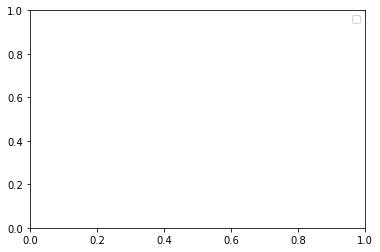

In [44]:
images = principal_DBN_alpha()

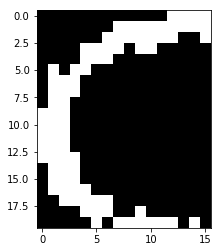

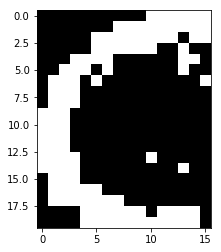

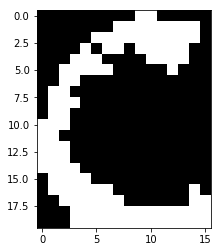

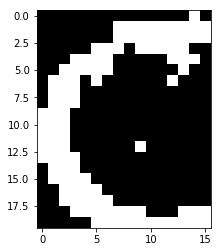

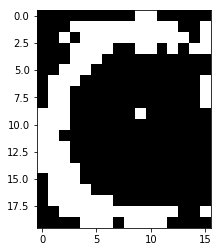

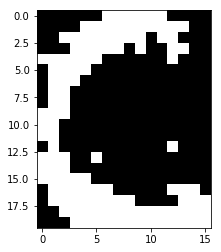

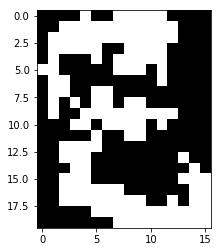

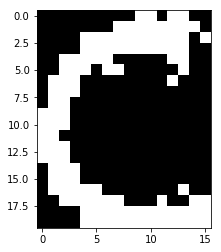

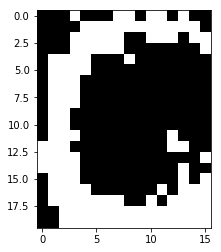

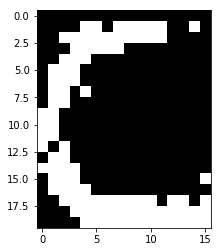

In [45]:
display(images,[20,16])

## III.3) Construction d'un DNN et test sur MNIST

In [22]:
'''
Input:
    data_name : fichier de données MNIST
    label_name : fichier des labels
    nb_data : nombre d'images voulues
Output:
    4 matrices: X_train, X_test, Y_train, Y_test
'''
def load_data(data_name, label_name, nb_data):
    train,train_labels = loadlocal_mnist(
    images_path=data_name,
    labels_path=label_name)
    train = train[:nb_data, :]
    train_labels = train_labels[:nb_data]
    X_train, X_test, Y_train, Y_test = train_test_split(train, train_labels, test_size=0.2, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [23]:
'''
Input: une matrice d'images en couleur
Output: une matrice d'images en noir et blanc
'''
def convert_image(X):
    comp = np.ones((X.shape[0], X.shape[1]))*10
    X = X <= comp
    return X

In [24]:
'''
Input:
    RBM: un RBM initialisé
    X: une matrice d'images
Output:
    Matrice de probabilités de sortie à partir de la fonction softmax
'''
def calcul_softmax(RBM,X):
    B = np.array([RBM.B]*X.shape[0])
    numerator = np.exp(np.dot(X, RBM.W) + B)
    denum = numerator.sum(1)
    result = np.zeros(numerator.shape)
    for i in range(result.shape[1]):
        result[:,i] = denum           
    return numerator/result

In [25]:
'''
Input: 
    DNN : un DNN entrainé
    X : une matrice d'images
Output:
    sorties : sorties de toutes les couches du réseau
    probas : sortie de la dernière couche (prédiction)
'''
def entree_sortie_reseau(DNN,X):
    sorties = []
    for RBM in DNN[:-1]:
        X = entree_sortie_RBM(X,RBM)
        sorties.append(X)
   
    probas = calcul_softmax(DNN[-1],sorties[-1])
    return sorties,probas

In [68]:
'''
Input:
    DNN : un DNN initialisé (et?) entrainé
    nb_iter_grad : nombre d'itérations de la descente de gradient
    mini_batch_size : taille du minibatch
    X : une matrice d'images
    label : les labels de nos données
Output:
    DNN : Un DNN ayant subit une rétropropagation
    Entropie : liste des entropies croisées pour chaque itération
'''
def retropropagation(DNN,nb_iter_grad,alpha,mini_batch_size,X,label, test_mode=False):
    
    Entropie = []
    for iteration in range(nb_iter_grad):
        
        # Pour shuffle X, on a aussi besoin de shuffle les labels. Donc on shuffle les indices, et on récupère les données dans cet ordre
        l = np.arange(X.shape[0])
        np.random.shuffle(l)
        X = X[l,:]
        label = label[l,:]
    
        n = len(X)
        for batch in range(0,len(X),mini_batch_size):
            old_DNN = DNN[:]
            
            # selection des données
            donnees_batch = X[batch:min(batch + mini_batch_size, len(X))]
            label_batch = label[batch:min(batch + mini_batch_size, len(X))]
            sorties,probas = entree_sortie_reseau(old_DNN,donnees_batch)
            
            for i in range(len(old_DNN)-1,-1,-1):

                #si dernière couche
                if i == len(old_DNN)-1 :
                    matrice_c = probas - label_batch
                    der_W = np.dot(np.transpose(sorties[-1]),matrice_c)/donnees_batch.shape[0]
                    der_b = np.sum(matrice_c,axis=0)/donnees_batch.shape[0]

                #Pour les autres couches
                else:
                    if i == 0:
                        data = donnees_batch
                    else:
                        data = sorties[i-1]
                        
                    h_1_h = sorties[i]*(1-sorties[i])
                    transit = np.dot(matrice_c,np.transpose(old_DNN[i+1].W))
                    matrice_c = transit*h_1_h
                    
                    der_W = np.dot(np.transpose(data),matrice_c)/donnees_batch.shape[0]
                    der_b = np.sum(matrice_c,axis=0)/donnees_batch.shape[0]

                old_DNN[i].W -= alpha*der_W
                old_DNN[i].B -= alpha*der_b
            
        
            DNN = old_DNN[:]
        sortie,probas = entree_sortie_reseau(DNN,X)
        entropie = np.sum(-np.sum(label*np.log10(probas),axis=0), axis=0)/n
        print(entropie)
        Entropie.append(entropie)
  
    return DNN,Entropie

In [64]:
'''
Input : Liste des entropies croisées
Output : trace l'évolution de l'entropie
'''
def tracer_entropie(Entropie):  
    plt.plot(range(len(Entropie)), Entropie)
    plt.legend(['Entropie'])
    plt.title("Évolution de l'Entropie")

In [65]:
'''
Input:
    DNN : un DNN entrainé et/ou ayant subit une rétropropagation
    X_test : la matrice des données/images test
    label_test : les labels associés
Output:
    Le taux de bonne prédiction
'''
def test_DNN(DNN, X_test, label_test):  
    sorties, probas = entree_sortie_reseau(DNN, X_test)
    index_max = np.argmax(probas, axis=1)
    accuracy_rate = 0
    for i, j in enumerate(index_max):
        values = np.zeros((DNN[-1].W.shape[1]))
        values[j] = 1
        probas[i,:] = values
    for labels in range(label_test.shape[0]):
        if (probas[labels, :]==label_test[labels]).all():
            accuracy_rate += 1
    return accuracy_rate/label_test.shape[0]*100

In [66]:
def principal_DNN_MNIST():
    
    # Initialisation des paramètres
    nb_iter = 100
    alpha = 0.05
    mini_batch_size = 10
    nb_data_train = 1000
    image_size = [28, 28]
    nb_images = 10
    nb_data_test = 20
    
    # Chargement des données
    X_train, X_test, Y_train, Y_test = load_data('./train-images.idx3-ubyte', './train-labels.idx1-ubyte', nb_data_train)
    X_train = convert_image(X_train)
    X_test = convert_image(X_test)
    
    # Initialisation de la taille du réseau
    network_layers = [X_train.shape[1], 200, 120, 60, 10]
    
    # Préparation des labels
    Y_train_reshape = np.zeros((Y_train.shape[0], network_layers[-1]))
    Y_test_reshape = np.zeros((Y_test.shape[0], network_layers[-1]))
    for i in range(len(Y_train)):
        Y_train_reshape[i, Y_train[i]] = 1
    for i in range(len(Y_test)):
        Y_test_reshape[i, Y_test[i]] = 1
    
    # On initialise le RBM
    DNN = init_DNN(network_layers)
    
    # On l'entraine
    DNN = train_DBN(DNN,nb_iter,alpha,mini_batch_size,X_train)
    
    # On applique la rétro propagation
    DNN,entropie = retropropagation(DNN,nb_iter,alpha,mini_batch_size,X_train,Y_train_reshape, test_mode=False)
    
    # On le test
    rate = test_DNN(DNN, X_test, Y_test_reshape)
    
    # On trace l'entropie
    tracer_entropie(entropie)
    return rate

1.0236531099107322
1.064659813435075
1.02894932141245
1.0241792359531168
1.0101964611133658
1.0216560826597685
1.0456889275641523
1.0164348700283314
1.0222075702685653
1.0142220666215473
1.029944589554417
1.0421635437943098
1.0125974684586132
1.0128796092795234
1.046326877278813
1.0210755274406678
1.0214984454929437
1.0153319011119388
1.0394244206888457
1.0352331691954761
1.0092754048878694
1.0234788614970691
1.0299827082020465
1.0139937095640594
1.0295789238237059
1.0173364066899275
1.0409029172641378
1.0304267703616952
1.0271509782162547
1.0285352184299037
1.019523537827954
1.013168083493391
1.022579056957855
1.036583560820206
1.04733670327976
1.0444879905288083
1.049208393873573
1.0268496053571003
1.0190660873952662
1.0206683413729403
1.0594843271808332
1.0277203256572418
1.024536237803528
1.008706819477421
1.0317924464543544
1.028970151751529
1.0077818431019896
1.0285298367527689
1.0569716215470737
1.023153592640978
1.0133681428555257
1.0351003766645415
1.0500983513983306
1.0318495

10.0

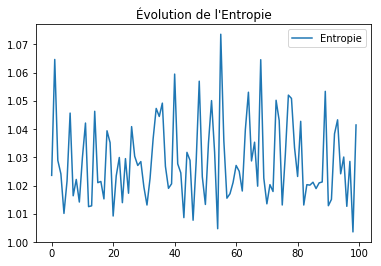

In [70]:
principal_DNN_MNIST()

# IV) Travail préliminaire (Binary AlphaDigit)

# V) Étude à réaliser (MNIST)